#### Setup
The data is set up, split, and pre-processed using the same process as before. 

In [1]:
import nltk
import time
import eli5
import string
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

from eli5.lime import TextExplainer
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords 
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, sent_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer 

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score,f1_score, classification_report

sns.set_style("whitegrid")
sns.set_palette("rocket")

warnings.simplefilter(action='ignore')

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/lois/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lois/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lois/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
#load in data
suicide = pd.read_csv("/Users/Lois/Downloads/ML ipynb/Capstone/SuicideDetection.csv")
suicide = suicide.sample(20000, random_state = 42)

In [4]:
#only keeping the text and class columns
suicide.drop("Unnamed: 0", axis = 1, inplace = True)

#renaming "class" column as "suicide"
suicide.rename({"class" : "suicide"}, axis = 1, inplace = True)

#numerically representing the contents of "suicide" column
suicide.replace({"suicide" : 1, "non-suicide" : 0}, inplace = True)
suicide.head()

,text,suicide
74414,I Don't know?7? Months self harm free and the ...,1
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,0
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",0
14043,I've honestly got no idea what to do anymore.I...,1
30673,Do you ever just cry? Like you just think abou...,0


In [5]:
#train test split
X = suicide['text']
y = suicide['suicide']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [6]:
#tokenization, stop word removal, punctuation removal, lower casing, and stemming
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case = False)
    swords = stopwords.words('english')
    punc = list(string.punctuation)
    stemmer = PorterStemmer()
    
    proprocessed_text = []
    for entry in text:
        tokens = tokenizer.tokenize(entry)
        proprocessed_text.append([stemmer.stem(word) for word in tokens if word not in swords and word not in punc])
    return proprocessed_text

In [7]:
#preprocessing
pX_train = preprocess_text(X_train)
pX_train = [' '.join(x) for x in pX_train]

pX_test = preprocess_text(X_test)
pX_test = [' '.join(x) for x in pX_test]

In [8]:
#adding a column of preprocessed text to the df
suicide['pX'] = preprocess_text(X)

In [9]:
#updated df 
suicide.head()

,text,suicide,pX
74414,I Don't know?7? Months self harm free and the ...,1,"[know, 7, month, self, harm, free, urg, get, s..."
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,0,"[start, becom, rich, start, compani, becom, 16..."
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",0,"[poem, haiku, u, me-game-dev, hi, hello, hello..."
14043,I've honestly got no idea what to do anymore.I...,1,"[i'v, honestli, got, idea, anymore.it, feel, e..."
30673,Do you ever just cry? Like you just think abou...,0,"[ever, cri, like, think, unfair, life, cri, ca..."


### Model Evaluation 

We begin by re-fitting the optimal SVC model using the results of RandomizedSearchCV.

In [17]:
#re-fitting model
vec = TfidfVectorizer()
svc = SVC(kernel = 'linear', probability = True, C = 1)

svc_pipe = Pipeline([
    ('tfidf', vec),
    ('svc', svc)
]).fit(pX_train, y_train)

#### Model Statistics

This model has an accuracy of 0.924, a precision of 0.92, a recall of 0.92, and an f1-score of 0.92.

In [76]:
y_pred = svc_pipe.predict(pX_test)
print(classification_report(y_test, y_pred))
print("accuracy: {:0.5f}".format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2487
           1       0.93      0.92      0.92      2513

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000

accuracy: 0.92440


#### Model Testing

We can test this model by using it to predict individual posts by passing in the text of a single entry from the data, then comparing the model's predicted class and the actual class. This model correctly predicts the class of these two data points, which are respectively non-suicidal and suicidal. Shown below are the original, un-preprocessed Reddit text, but note that the model's predictions will be based on the preprocessed counterpart, or the pX column. Recall that class 0 = not suicidal and class 1 = suicidal.

##### Example prediction of a non-suicidal post



In [20]:
#example prediction of the first datapoint
y_pred0 = svc_pipe.predict(pX_test)[0]
print(f'Predicted class: {y_pred0} \nActual class: {y_test.iloc[0]} \nPost: {X_test.iloc[0]}')

Predicted class: 0 
Actual class: 0 
Post: A teenage love story. So it all started in 2nd grade. I really liked that one girl in my class (let's call her Sara for sake of privacy) and never knew how to tell her. 

Fast forward to 3rd grade and our teacher was pissed at our class so she decided to rearrange our seats, now... take a hot guess, who was chosen to seat with me. If you guessed Sara, you were right.

We started getting along, having fun on lessons and lunch breaks. We were best friends.

Fast forward again now to 4th grade. All the classes were mixed and we sadly weren't in the same one. We still hung out and stuff but didn't have as much time for each other as before. Year 2016, February 14th, Valentines day. "It's my chance!" so since we didn't finish lessons at the same time I gave my close friend a letter from me to give to her after school. He gave it to her. Same day, just after class, she messages me and tells me she had a big crush on me since 1st grade "The fuck!?" w

##### Example prediction of a suicidal post**

In [21]:
y_pred1 = svc_pipe.predict(pX_test)[1]
print(f'Predicted class: {y_pred1} \nActual class: {y_test.iloc[1]} \nPost: {X_test.iloc[1]}')

Predicted class: 1 
Actual class: 1 
Post: I don't want to feel this way.I just want to get my meds straightened out and be happy. I don't want to feel sad, worthless, or like life is pointless. I want to enjoy life again and feel like others love me. 

I just need someone to tell me that it'll all get straightened out and I'll be happy again. I really need some one to reassure me because it all feels so bleak. I'm sorry. 


### Model Interpretation

Now that we've ascertained our model's capacity to correctly classify social media posts as suicidal or not, we will move on to interpret the features (words) chosen by the model to facilitate this performance. There are two general ways to evaluate a classification model. (1) A global analysis is concerned with identifying the weights the model as a whole assigns individual features, while (2) a local analysis looks at the features used in making an individual prediction. We will be using both evaluation methods and considering model (global) and individual (local) feature importances.


We begin by using the ELI5 and LIME libraries to formulate a global analysis of the optimal SVC model.



#### Model feature weights

The eli5.show_weights() function shows what the model learned by displaying the feature weights it assigned. Below are the top fifteen features our SVC pipeline model used to correctly identify suicidality in a post (i.e. y = 1). The five most important features (stemmed words) have a weight over 3.1, and are, in descending order, ["suicid", "kill", "end", "pill", "life", "die"]. 

In [24]:
#model's most important features
eli5.show_weights(svc_pipe, vec = vec, top=15, target_names = y_test)

Weight?,Feature
+7.969,suicid
+5.339,kill
+3.849,end
+3.259,pill
+3.131,life
+3.015,die
+2.878,live
+2.768,hang
+2.659,anymor
+2.657,overdos


#### Feature importance in individual predictions

We continue with a local analysis of two predictions, one for a suicidal post and the second for a non-suicidal post. eli5.lime.TextExplainer demarcates the prediction of individual data points, showing the salient features (in green gradient) used in predicting the class of an individual document. A red highlight indicates a negative feature importance, meaning that the word reduces the prediction value and increases the loss. 

**Example non-suicidal post**

The following is the prediction made for a non-suicidal post. We can see the most important/helpful words (strength indicated by the green saturation level), as well as the least helpful words below. 

In [305]:
te = TextExplainer(random_state = 42)
te.fit(pX_test[3], svc_pipe.predict_proba)
te.explain_weights()

Explanation(estimator="SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',\n              random_state=RandomState(MT19937) at 0x7FC8D9C51C40)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='finger feel', weight=0.4577541815406036, std=None, value=None), FeatureWeight(feature='felt fuck', weight=0.32762019918382196, std=None, value=None), FeatureWeight(feature='ton guitar', weight=0.32436262233602664, std=None, value=None), FeatureWeight(feature='notic felt', weight=0.3106984188742033, std=None, value=None), FeatureWeight(feature='finger bleed', weight=0.29944369939692095, std=None, value=None), FeatureWeight(feature='guitar ig', weight=0.2779364703504782, std=None, value=None), FeatureWeight(feature='kind numb', weight=0.26208513326903204, std=None, value=None)], neg=[FeatureWeight(feature='lol', weight=-0.9551820948033064, std=None, value=None), FeatureWeight(feature='play', weight=-0.7537769303904608, std=None, value=None), FeatureWeight(feature='weird', weight=-0.7112226555591269, std=None, value=None), FeatureWeight(feature='ig', weight=-0.6808781965023376, std=None, value=None), FeatureWeight(feature='fun', weight=-0.6463467406281844, std=None, value=None), FeatureWeight(feature='finger', weight=-0.5909820959524905, std=None, value=None), FeatureWeight(feature='ton', weight=-0.5760284468565288, std=None, value=None), FeatureWeight(feature='second', weight=-0.5451364748055783, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=-0.5231035841202002, std=None, value=None), FeatureWeight(feature='bc', weight=-0.48613287800031424, std=None, value=None), FeatureWeight(feature='realli', weight=-0.41242271987589313, std=None, value=None), FeatureWeight(feature='hand', weight=-0.34812709629276584, std=None, value=None), FeatureWeight(feature='kind', weight=-0.3255499325476527, std=None, value=None)], pos_remaining=19, neg_remaining=4), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [306]:
te.show_prediction()

**Validating the explanation**

To know if these explanations are valid, i.e. if the models built with LIME are representative of the black box model and can adequately predict the weights assigned by the black box model, we will evaluate the similarity between the local model and the black box/parent model. To do this, we will compare the two models' output given held-out data: if they make the same class predictions on unseen data, the local model is a good representation of the parent model. We can measure this with KL-Divergence, which tells you how similar two probability distributions are; a good local model should have a highly similar probability distribution to the black box model for the same inputs.

An implementation is provided in ELI5. The output score metric is the local model accuracy, indicating the KL-Divergence is low. In other words, the mean divergence in predictions across the entire dataset is ~1%.

In [314]:
te.metrics_

{'mean_KL_divergence': 0.010350366284158372, 'score': 0.9962330062714532}

**Example suicidal post**

The following shows the prediction made for a suicidal post (class = 1). The five most important words are ["it", "life", "worthless", "sorri", "feel"], while the five least helpful features are ["straighten", "like", "bleak", "happi", "love"]. 

In [315]:
te = TextExplainer(random_state = 42)
te.fit(pX_test[1], svc_pipe.predict_proba)
te.explain_weights()

Weight?,Feature
+0.975,it
+0.957,life
+0.635,worthless
+0.610,sorri
+0.475,feel
+0.447,want
+0.399,med
+0.359,ll
+0.310,way
+0.299,other


In [316]:
te.show_prediction()

**Validating the explanation**

The KL-divergence for this prediction is also very low, ~0.01. 

In [317]:
te.metrics_

{'mean_KL_divergence': 0.011976050016523378, 'score': 0.9795101011290771}

### Conclusion

This study shows that a word's presence in a document/social media post plays a significant role in the task of identifying individuals with suicide ideation -- some words more than others. A simple key word search/match can be quite effective in detecting risk for suicide in an individual. 

#### Visualizing class vocabularies

Word clouds can be used to visualize the most representative (common) words of each class (below). 

In [301]:
#collecting preprocessed words from the posts of both classes
suicide_words = suicide.query('suicide == 1')['pX'].sort_values(ascending = False)
non_suicide_words = suicide.query('suicide == 0')['pX'].values

#flattening the list of lists 
suicide_words = [word for sublist in suicide_word_list for word in sublist]
non_suicide_words = [word for sublist in non_suicide_word_list for word in sublist]
all_words = suicide_words + non_suicide_words

print(len(suicide_words))
print(len(non_suicide_words))
print(len(all_words))

953983
378928
1332911


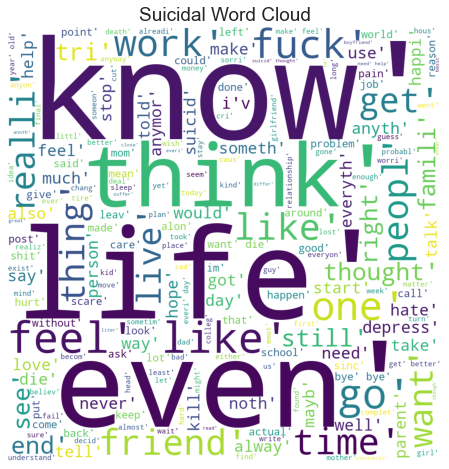

In [166]:
#suicide word cloud 
s_wordcloud = WordCloud(width = 900, height = 900, stopwords = STOPWORDS, background_color = 'white').generate_from_text(str(suicide_words))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(s_wordcloud)
plt.axis('off')
plt.title("Suicidal Word Cloud", fontsize = 19)
plt.show()

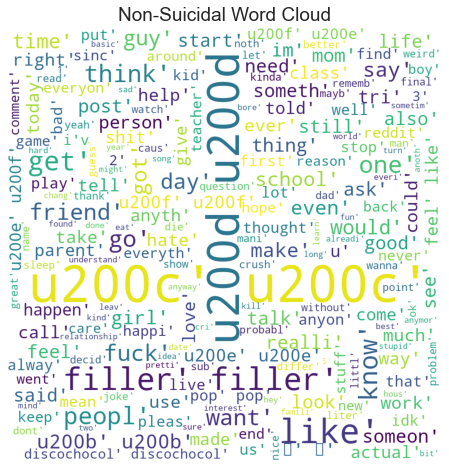

In [ ]:
#non-suicide word cloud 
x_wordcloud = WordCloud(width = 900, height = 900, stopwords = STOPWORDS, background_color = 'white').generate(str(non_suicide_words))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(x_wordcloud)
plt.axis('off')
plt.title("Non-Suicidal Word Cloud", fontsize = 19)
plt.show()

#### Future Work

Interestingly, the feature "feel" has a high contribution to classifying our second example post as suicidal, but a negative importance in classifying our first post as non-suicidal. This gives way to a theory that the absense of certain words is a significant feature in gauging a post's non-membership of a class -- and in a binary classification problem, its membership of the second class. Because it is impossible for a person/post to be both or neither suicidal nor non-suicidal, saying that a post is not [suicidal] is synonymous with saying it is [not suicidal].

**Next steps and recommendations**

We can explore this possibility by **using the pandas query function to compile two lists of words: Those that appear only in suicidal posts and those that only appear in non-suicidal posts.** One might begin by **building two vocabularies**, the first consisting of every unique word from the all the posts in the suicidal class, and the second consisting of every unique word from the non-suicidal class. It may be illuminating to **go through these two vocabularies and make a list of [words that appear in class 1 and not in class 0] and another list of [words that appear in class 0 and not in class 1]**. Additionally, one could **cross check the model permutation importance scores of words in these two lists to see if they have high absolute permutation importance values.**


Additionally, further work can be done in improving the performance of the best classification model. **The best model can be extended, further fine-tuned, or even replaced by experimenting with or incorporating other algorithms and techniques, such as ensemble methods or recurrent neural networks**. Future exploration can also be done in **crosschecking the importance of words, as indicated by the word cloud, and the words' weights, assigned by not just the SVC model but also the Logistic Regression, Decision Tree, and Naive Bayes models.**
